<a href="https://colab.research.google.com/github/CainCastor/Sentiment_Analysis_Using_CNN/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

In [ ]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.13.0


In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


**Let us define methods to pre-process the tweets**


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text):
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    return text2.lower()

**Let us pre-process the data**

In [ ]:
train_data= pd.read_csv("/content/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True)
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split()))
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("/content/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True)
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split()))

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------
-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


In [ ]:
train_data['sentiment'].value_counts()

neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64

In [ ]:
train_data.isnull().sum()

textID            0
text              0
selected_text     0
sentiment         0
Num_words_text    0
dtype: int64

In [ ]:
train_data.duplicated().sum()

0

**Let us split the training data into train and validation datasets Let us convert our training,validation and test data into the format accepted by tensorflow**

In [ ]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 58, 21, 4]]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


<ipython-input-12-1f651ba4dc1f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
<ipython-input-12-1f651ba4dc1f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
<ipython-input-12-1f651ba4dc1f>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break

Streaming output truncated to the last 5000 lines.
[  11   66   73 1693    7    9   52  431    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  6 157  28 637   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  85    7   40    6  299  337 1127    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  56 1630    5 5337    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

**Let us create a simple Convolutional Neural Network model**



In [ ]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))




model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1305155 (4.98 MB)
Trainable params: 1305155 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

**Let's train our model**

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - 9s 42ms/step - loss: 1.0622 - categorical_accuracy: 0.5421 - val_loss: 0.8142 - val_categorical_accuracy: 0.6910
Epoch 2/100
189/189 [==============================] - 7s 35ms/step - loss: 0.8012 - categorical_accuracy: 0.6999 - val_loss: 0.7797 - val_categorical_accuracy: 0.7160
Epoch 3/100
189/189 [==============================] - 7s 39ms/step - loss: 0.7637 - categorical_accuracy: 0.7277 - val_loss: 0.7834 - val_categorical_accuracy: 0.7201
Epoch 4/100
189/189 [==============================] - 8s 40ms/step - loss: 0.7370 - categorical_accuracy: 0.7465 - val_loss: 0.7989 - val_categorical_accuracy: 0.7246
Epoch 5/100
189/189 [==============================] - 7s 36ms/step - loss: 0.7213 - categorical_accuracy: 0.7634 - val_loss: 0.8152 - val_categorical_accuracy: 0.7276
Epoch 6/100
189/189 [==============================] - 7s 38ms/step - loss: 0.7047 - categorical_accuracy: 0.7779 - val_loss: 0.8273 - val_categorical_accuracy: 0.7250
Epoc

In [ ]:
history.history

{'loss': [1.0621596574783325,
  0.8012316226959229,
  0.7637135982513428,
  0.7369601726531982,
  0.7213258147239685,
  0.7046958804130554,
  0.6901460886001587,
  0.6748067736625671,
  0.6610214114189148,
  0.6490103006362915,
  0.6343756914138794,
  0.6267427206039429,
  0.6147984862327576,
  0.6073157787322998,
  0.5960962176322937,
  0.5898231267929077,
  0.5842716693878174,
  0.5740154385566711,
  0.5658464431762695,
  0.5612822771072388,
  0.5565208196640015,
  0.5552998781204224,
  0.5489578247070312,
  0.5442197322845459,
  0.5425169467926025,
  0.5411862134933472,
  0.5362064838409424,
  0.5295385122299194,
  0.5301291942596436,
  0.5253825783729553,
  0.5192986130714417,
  0.5199769139289856,
  0.5200504064559937,
  0.516012966632843,
  0.5169106721878052,
  0.5145941972732544,
  0.5086360573768616,
  0.5072834491729736,
  0.5040116906166077,
  0.5060068964958191,
  0.5050875544548035,
  0.4981946349143982,
  0.49996963143348694,
  0.5009145140647888,
  0.49493563175201416,
 

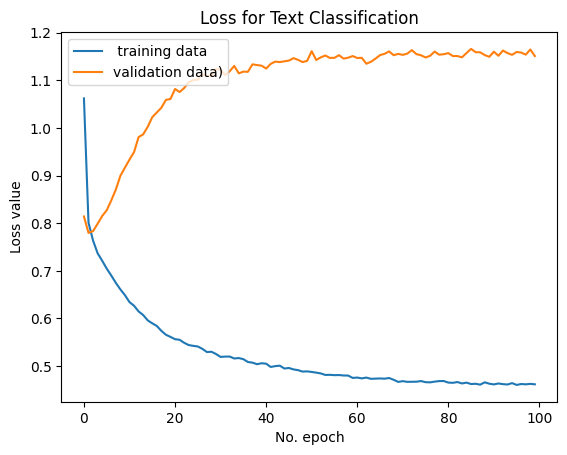

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

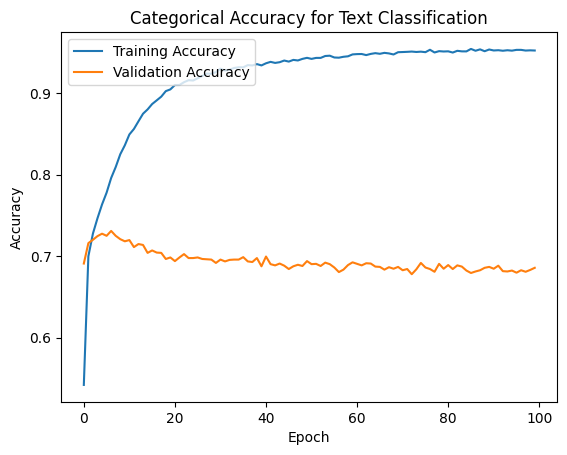

In [ ]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Categorical Accuracy for Text Classification')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()